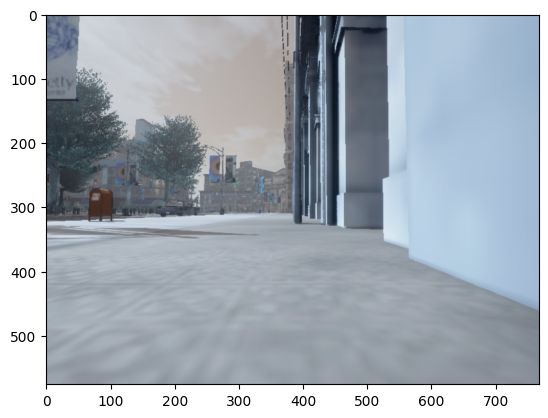

: 

In [ ]:
import carla
import random
import math
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

client = carla.Client('127.0.0.1', 2000)
world = client.get_world()

for vehicle in world.get_actors().filter('*vehicle*'):
    print("yeye")
    #vehicle.set_autopilot(True)
    vehicle.destroy()

def process_img(image):
    i = np.array(image.raw_data)
    i2 = i.reshape((image.height, image.width, 4))
    i3 = i2[:, :, :3]
    return i3

def capture_image(image, vehicle_id, angle, height, pitch, cam):
    image = process_img(image)
    plt.imshow(image)
    plt.show()
    clear_output(wait=True)
    cam.destroy()
    # Save the image logic here

def get_camera_transform(vehicle_transform, angle, distance, height):
    angle_rad = math.radians(angle)
    location = vehicle_transform.location
    x = location.x + distance * math.cos(angle_rad)
    y = location.y + distance * math.sin(angle_rad)
    z = height

    # Calculate the direction vector from the camera to the vehicle
    direction = carla.Location(location.x - x, location.y - y, location.z - z)
    pitch = -math.degrees(math.atan2(direction.z, math.sqrt(direction.x**2 + direction.y**2)))
    yaw = math.degrees(math.atan2(direction.y, direction.x))

    return carla.Transform(carla.Location(x=x, y=y, z=z), carla.Rotation(pitch=pitch, yaw=yaw))



vehicle_blueprints = world.get_blueprint_library().filter('vehicle.*')
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', str(800 - (800 % 64)))  # 800 is the nearest multiple of 64
camera_bp.set_attribute('image_size_y', str(600 - (600 % 64)))  # 600 is the nearest multiple of 64
camera_bp.set_attribute('fov', '90')

vehicle_bp = random.choice(vehicle_blueprints)
spawn_point = world.get_map().get_spawn_points()[4]
vehicle = world.spawn_actor(vehicle_bp, spawn_point)

distance_from_vehicle = 10  # distance in meters
camera_height = .5  # height in meters

for angle in range(0, 360, 18):  # Adjust step for finer or coarser rotation
    camera_transform = get_camera_transform(vehicle.get_transform(), angle, distance_from_vehicle, camera_height)
    camera = world.spawn_actor(camera_bp, camera_transform)

    camera.listen(lambda image: capture_image(image, vehicle.id, angle, camera_height, -15, camera))
    time.sleep(1)  # Adjust sleep time as needed

vehicle.destroy()


In [1]:
import carla
import random
import math
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import subprocess


def process_img(image):
    i = np.array(image.raw_data)
    i2 = i.reshape((image.height, image.width, 4))
    i3 = i2[:, :, :3]
    return i3

def check_if_image_already_exists(vehicle_id, angle, height, pitch, distance,left_shift, color):
    return os.path.exists(f'D:/SelfDrivingImages/{vehicle_id}/ang{angle}h{height}p{pitch}dist{distance}lshift{left_shift}color{color}.png')

def capture_image(image, vehicle_id, angle, height, pitch, distance,left_shift, cam):
    try:
        image.save_to_disk(f'D:/SelfDrivingImages/{vehicle_id}/ang{angle}h{height}p{pitch}dist{distance}lshift{left_shift}color{color}.png')# % image.frame)
        
        if False:
            image = process_img(image)
            # Create a figure and axis to plot the image
            fig, ax = plt.subplots()
            ax.imshow(image)

            # Set text with angle, height, and distance information
            text_str = f"Angle: {angle}°, Height: {height}m, Distance: {distance}m Pitch: {pitch} Lshift: {left_shift}"
            ax.text(0.05, 0.95, text_str, color='white', fontsize=8, ha='left', va='top', transform=ax.transAxes)

            if not os.path.exists(f'D:/SelfDrivingImages/{vehicle_id}'):
                os.makedirs(f'D:/SelfDrivingImages/{vehicle_id}')
            # Show the image
            plt.savefig(f'D:/SelfDrivingImages/{vehicle_id}/ang{angle}h{height}p{pitch}dist{distance}lshift{left_shift}.png')
            
            clear_output(wait=True)
        cam.destroy()
    except:
        None

# def get_camera_transform(vehicle_transform, angle, distance, height, pitch):
#     angle_rad = math.radians(angle)
#     location = vehicle_transform.location
#     x = location.x + distance * math.cos(angle_rad)
#     y = location.y + distance * math.sin(angle_rad) 
#     z = height

#     direction = carla.Location(location.x - x, location.y - y, location.z - z)
#     yaw = math.degrees(math.atan2(direction.y, direction.x))

#     return carla.Transform(carla.Location(x=x, y=y, z=z), carla.Rotation(pitch=pitch, yaw=yaw))

def get_camera_transform(vehicle_transform, angle, distance, height, pitch, left_shift=0):
    # Convert angle to radians
    angle_rad = math.radians(angle)

    # Original location calculation
    location = vehicle_transform.location
    x = location.x + distance * math.cos(angle_rad)
    y = location.y + distance * math.sin(angle_rad)
    z = height

    # Calculate camera direction vector
    direction = carla.Location(location.x - x, location.y - y, location.z - z)

    # Calculate the perpendicular vector for left shift
    # It's perpendicular to the direction in which the camera is looking
    left_shift_vector = carla.Location(-direction.y, direction.x, 0)

    # Normalize the left_shift_vector and apply the shift
    magnitude = math.sqrt(left_shift_vector.x**2 + left_shift_vector.y**2)
    left_shift_vector.x = (left_shift_vector.x / magnitude) * left_shift
    left_shift_vector.y = (left_shift_vector.y / magnitude) * left_shift

    # Apply the left shift to x and y
    x += left_shift_vector.x
    y += left_shift_vector.y

    # Calculate yaw from the direction vector
    yaw = math.degrees(math.atan2(direction.y, direction.x))

    # Return the new transform with the left shift applied
    return carla.Transform(carla.Location(x=x, y=y, z=z), carla.Rotation(pitch=pitch, yaw=yaw))

while True:
    try:
        client = carla.Client('127.0.0.1', 2000)
        client.set_timeout(10.0)
        world = client.get_world()

        for vehicle in world.get_actors().filter('*vehicle*'):
            print("yeye")
            vehicle.destroy()

        vehicle_blueprints = world.get_blueprint_library().filter('vehicle.*')
        camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
        camera_bp.set_attribute('image_size_x', str(800 - (800 % 64)))  # 800 is the nearest multiple of 64
        camera_bp.set_attribute('image_size_y', str(600 - (600 % 64)))  # 600 is the nearest multiple of 64
        camera_bp.set_attribute('fov', '90')

        vehicle_bp = random.choice(vehicle_blueprints)

        spawn_point = world.get_map().get_spawn_points()[4]

        vehiclelist = []
        colorlist = ["255,0,0", "0,255,0", "0,0,255", "0,255,255", "255,0,255", "255,255,0", "255,255,255", "0,0,0"]
        vehicle_blueprints = world.get_blueprint_library().filter('*vehicle.audi*')



        for vehiclebp in vehicle_blueprints:
            for color in colorlist:
                vehiclebp.set_attribute('color', color)
                vehicle = world.spawn_actor(vehiclebp, spawn_point)


                for angle in range(0, 361, 18):  # Adjust angle steps as needed
                    for height in range(2, 6, 3):  # Vary height
                        for distance in range(6, 11, 2):  # Vary distance
                            for pitch in range(-30,-10,8):
                                for left_shift in range(-3,4,2):
                                
                                    #for weather in weathers:
                                        #world.set_weather(weather)
                                    if(not check_if_image_already_exists( vehicle.type_id, angle, height, pitch, distance, left_shift, color)):
                                        camera_transform = get_camera_transform(vehicle.get_transform(), angle, distance, height, pitch, left_shift)
                                        camera = world.spawn_actor(camera_bp, camera_transform)
                                        camera.listen(lambda image: capture_image(image, vehicle.type_id, angle, height, pitch, distance,left_shift, camera))

                                        time.sleep(0.8)  # Adjust sleep time as needed
                print("finished")
                vehicle.destroy()
    except:
        subprocess.Popen(["D:/WindowsNoEditor/CarlaUE4.exe","-quality-level=Low", "-carla-port=2000"])
        time.sleep(15)

yeye
finished
finished
finished
finished
finished
finished
finished
finished


: 

NameError: name 'world' is not defined